# Bloqade Tutorial

This notebook accompanies QuEra's condensed tutorial on neutral-atom quantum computing for iQuHack 2024. It intends to provide students with the basic information needed to develop programs for neutral-atom quantum computing with Bloqade-python.


## Installation requirements and guidelines
In this tutorial, we will work with the Python version of Bloqade. For general details and functionality, we refer the reader to the [Bloqade-python documentation page](https://queracomputing.github.io/bloqade-python/0.7.2/). For Python installation guidelines, refer to [Python's homepage](https://www.python.org/about/).

To operate Bloqade-python, Jupyter notebooks are not necessary, but will be convenient for this tutorial. You can install JupyterLab or the classical Jupyter notebooks via terminal using pip. Just open a terminal and type `pip install jupyterlab` or `pip install notebook`, respectively. These can be run either on your browser or IDE of choice. 

With this in order, installing Bloqade-python is as simple as typing `pip install bloqade` on your terminal or notebook.

Now let's have fun!

## Quantum simulations in 5 steps

Solving problems with a neutral-atom analog quantum computer is different from doing quantum computing with gates. Qubit interactions and connectivity can be defined ad-hoc, the user may literally choose what their processor looks like, and a clear knowledge of the Hamiltonian that control the qubit dynamics is needed.

We will get back to these details in a second. First, let's focus on workflow. The process of encoding a problem in a neutral-atom analog simulator involves 5 general steps:

1. Define the atoms/qubits positions
2. Define time traces of Hamiltonian parameters (i.e., the algorithm)
3. Initialize the problem (starting qubit register and Hamiltonian)
4. Perform time evolution (the analogue of composing gates)
5. Measure for results

In what follows, we will focus on point 1 and 2. Session II of this tutorial will cover packing it all together into some applications that will cover all steps together using Bloqade's simulation backends. Via Bloqade, one can either perform classical emulations of quantum hardware, or submit jobs to real quantum hardware. While Session III will focus on how to submit jobs to Aquila, QuEra's quantum computer available on the cloud. These three sessions cover all the basics necessary to operate neutral-atom computers. Subsequent lessons will cover more advanced concepts, applications, and aspects of quantum computing with neutral atoms.

## The Hamiltonian

The steps above come together as a way to conduct the atomic qubits according to their natural interactions. These interactions, and the subsequent dynamics, are controlled by a quantum Hamiltonian operator, which in Bloqade and several neutral-atom simulators reads as follows,

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_j \frac{\Omega_j(t)}{2} \left( e^{i \phi_j(t) } | 0_j \rangle  \langle 1_j | + e^{-i \phi_j(t) } | 1_j \rangle  \langle 0_j | \right) - \sum_j \Delta_j(t) \hat{n}_j + \sum_{j < k} V_{jk} \hat{n}_j \hat{n}_k.
$$

Here, $| 0_i \rangle,$  $| 1_i \rangle,$ and $\hat{n}_i= 0|0_i \rangle  \langle 0_i | + 1| 1_i \rangle  \langle 1_i | $  refer to qubits in a position $i$ of space. Referring to step 1 in the previous section, the user's first job is to define, geometrically (in micrometers for Bloqade), what are the allowed positions. Bloqade accepts nearly arbitrary geometries in 2D. 

Fixing these geometric positions is crucial because the interaction term between qubits $i$ and $j$, $V_{ij}\equiv C_6/r_{ij}^6$, decays with the distance between the qubits to the 6th power. $C_6$ is just a constant. This interaction imparts a positive energy cost to the Hamiltonian, meaning that if qubits are too close, effectively, the state where both qubits are $1$ has too much energy to be accessed and is effectively expelled from the Hilbert space (this is called the Rydberg blockade phenomenon). 

Naturally the story above is a bit simplified. Defining algorithms, our step 2 above, requires manipulating the time-traces of the Hamiltonian parameters $\Omega_i(t)$, $\phi_i(t)$, and $\Delta_i(t)$. The Rabi term $\Omega$ and detuning $\Delta$ introduce energy scales that compete with the geometrically controlled scale $V_{ij}$.


In a real device, like Aquila, constraints exist for the values of position and time-dependent functions. If you intend to create simulations that can be deployed on real hardware, make sure to consult the capabilities documented [here](https://queracomputing.github.io/Bloqade.jl/dev/capabilities/) (this is in Bloqade-julia's documentation page). The examples below will be following the limitations imposed by the hardware.

From here on, we move to real practice.

*disclaimer about units: programming Bloqade requires awareness of the physical units of the parameters you define. Make sure you remember all length quantities are defined in $\mu m$, while energies are measured in $MHz$ or (for Aquila runs) in $radians/\mu s$; it is common practice to include conversion factors of $2\pi$ in the definition of waveforms for energetic parameters on Bloqade.* 

### Preparations

To get started let's include some packages and modules that will be useful.

In [2]:
from bloqade import rydberg_h, piecewise_linear, piecewise_constant, waveform, cast
from bloqade.atom_arrangement import ListOfLocations, Lieb, Square, Chain, Honeycomb, Kagome, Triangular, Rectangular
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
import os
import matplotlib.pyplot as plt
import numpy as np

output_notebook()

Loading BokehJS ...

# I. Geometric controls

To determine the position of atoms, all we have to do is to convert a list of tuples, each corresponding to an ordered pair for the positions of our qubits in a cartesian plane (agin, in $\mu m$  units), into a `ListOfLocations`. For example:

In [2]:
atom_coordinate =ListOfLocations([(0.0, 0.0), (0, 5), (0, 8), (5, 2), (6, 7), (9, 6)])

visualization of the geometry you chose can be easily achieved by 

In [3]:
atom_coordinate.show()

For many applications, the positioning of qubits of interest follows a regular lattice pattern. Bloqade has shorthand lattice types for several useful lattices, all inside the `atom_arrangement` sub-module. These include the `Chain`, `Square`, `Rectangular`, `Honeycomb`, `Triangular`, `Lieb`, and `Kagome`. These come as atom arrangements right out of the box, so syntax is much simplified: call any of these geometries as functions, feeding them how many unit cells are desired in each primitive vector direction, and what is the lattice constant of choice (once more, to make sure we all remember, in $\mu m$).

Here goes an example for a uniform square (so a single integer number is needed to fix the geometry; for ''strips'', use `Rectangular`)

In [4]:
Square(4,4,lattice_spacing=5.2).show()

Bloqade facilitates many more manipulations on qubit register geometries. Furthermore, when operating programs later, we will see Bloqade-python also has some shortcuts to define atomic geometries more directly and with variable positions (say, for variational experiments).

# II. Dynamic controls

Generating waveforms is the essential step for generating and controlling a neutral-atom analog quantum processor. As discussed before, the parameters that can be determined by the user for different quantum protocols include the Rabi frequencies Ω, the detuning field Δ, and the phase ϕ. 

While Bloqade supports several built-in waveforms and allows the users to specify smooth waveforms by inputting functions, machine constraints dictate that piecewise linear and piecewise constant functions are the most relevant ones for real-world applications that can run on actual quantum devices.

Let's see how to compose piecewise linear and constant functions and plot them with Bloqade!

`piecewise_linear` takes as inputs a list of "durations", the time ranges of each piecewise linear segment, and another list containing the "values" for the begining and ending of each linear segment. Naturally, the latter will always have one more element than the former. Bloqade uses native units for its waveforms that facilitate aligning with hardware constraints, so that the waveform values are measured in units of MHz. Here go a couple of examples

In [5]:
durations = [0.2,1.2,1.2,1.2,0.2]
values = [-4.0,-4.0,4.0,-4.0,4.0,4.0]
waveform1 = piecewise_linear(durations, values)

waveform1.show()

In [6]:
durations = [0.2,3.6,0.2]
values = [0.0,2.5,2.5,0.0]
waveform2 = piecewise_linear(durations, values)

waveform2.show()

`piecewise_linear` waveforms are relevant for defining detunings $\Delta$ and Rabi amplitudes $\Omega$. Phases $\phi$, in Aquila, are fixed by `piecewise_constant` waveforms. Their definition operate roughly the same way on Bloqade, except that the list of values has one less element as each constant segment only requires one value to be uniquely determined:

In [7]:
durations = [1.0,2.0,1.0]
values = [0.0,np.pi/2,np.pi]
waveform_const = piecewise_constant(durations, values)

waveform_const.show()

## III. Your first Rydberg Hamiltonian

These waveforms and atomic positions are, so far, just general mathematical functions. To wrap up this lesson, let's package these mathematical functions into physical parameters of a neutral-atom system via the Rydberg Hamiltonian defined in the beginning of this notebook. The simplest way to turn the mathematical functions into the different detuning, Rabi amplitude, phase, and atom position choices for a system we want to emulate or study with Aquila via the `rydberg_h` method. Here is what the basic syntax looks like:

In [15]:
#geometry
rng = np.random.default_rng(1234)
atom_pos=Square(4, lattice_spacing=4).apply_defect_density(0.2, rng=rng).remove_vacant_sites()

max_delta = 58.48

#dynamics
durations = [0.1,3.7,0.2]
delta_MHz=[-max_delta, -max_delta, max_delta, max_delta]
omega_MHz= [0.0,15.8,15.8,0.0]

Delta = piecewise_linear(durations,[x for x in delta_MHz])
Omega = piecewise_linear(durations,[x for x in omega_MHz])

#create Hamiltonian
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)

program.parse_register().show()
program.parse_sequence().show()





Given a Hamiltonian describing a full program, we might as well run it to see what it does! Let's try first emulating the calculation.

In [16]:
output = program.bloqade.python().run(shots=100, interaction_picture=True)

The simplest information we can extract from this, are the one hundred bit strings (from our 100 shots) that resulted from the calculation. The information lies inside the `report()` method

In [17]:
output.report().bitstrings()

[array([[0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 0]], dtype=int8)]

With these bit strings, we can measure observables, compute statistics, and do our general analysis. But they are a bit clumsy. We can get more information by calling counts, which immediatelly return us the number of times each bit string appeared as result of our calculation:

In [18]:
output.report().counts()

[OrderedDict([('011011111110110', 98),
              ('011011101111110', 1),
              ('011011111010111', 1)])]

Another option is to extract the meanvalue of some observables. For example, measuring $Z_i$ for site $i$, we can compute the mean Rydberg-state occupation density accross the system 

In [19]:
output.report().rydberg_densities()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
task_number,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.01,0.0,0.01,0.0,0.99,0.0,0.0,0.99


For convenience, basic data analysis and visualization can be obtained via Bloqade with a single show command on the report

In [20]:
output.report().show()

In [71]:
#geometry
rng = np.random.default_rng(1234)
atom_pos=Square(14, lattice_spacing=4).apply_defect_density(0.2, rng=rng).remove_vacant_sites()

max_delta = 58.48

#dynamics
durations = [0.1,3.7,0.2]
delta_MHz=[-max_delta, -max_delta, max_delta, max_delta]
omega_MHz= [0.0,15.8,15.8,0.0]

Delta = piecewise_linear(durations,[x for x in delta_MHz])
Omega = piecewise_linear(durations,[x for x in omega_MHz])

#create Hamiltonian
program = rydberg_h(atom_pos, detuning= Delta, amplitude=Omega, phase=None)

program.parse_register().show()
program.parse_sequence().show()


# Submitting jobs to quantum hardware

Now let's move on to submitting the same program to a real quantum computer; Aquila to the rescue! 
The process is exactly the same as above, exchanging `bloqade` for `braket` (the gate-way to Aquila) and the `python` backend to `aquila` itself. Finally, let's remember to run asynchronously, so that your computer does not get stuck waiting for the return of the job submission.

In [4]:
from bloqade import load, save


In [4]:
output_Q = program.braket.aquila().run_async(shots=100)

Retrieving data requires just fetching it from the variable where we saved our program

In [12]:
output_Q.fetch()

                                             task ID     status  shots
0  arn:aws:braket:us-east-1:592242689881:quantum-...  Completed    100

To ensure you can always retrieve the data, even after closing your notebook, the safe process is to use the `save` command from Bloqade. It will generate a file with the correct metadata that, once loaded, will always be able to retrieve the results of a given task submission.

In [9]:
save(output_Q, "kings_first_test")
new_output = load("kings_first_test")

Finally, reporting works exactly the same way as it worked when doing emulations

In [5]:
new_output = load("first_aquila_test_2a")
new_output.report().show()

/home/jovyan/.qbraid/environments/bloqade_do0v1w/pyenv/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


That is it! This closes the pipeline for interacting with Aquila.

Probably many questions arised in your mind. How do you handle multiple tasks, or can you define variables to change in your program? Bloqade actually contains much more functionalities, supporting batching and quality-of-life features for variational programs. Feel free to reach 

In [34]:
new_output.report().bitstrings()[0][0].shape

(152,)

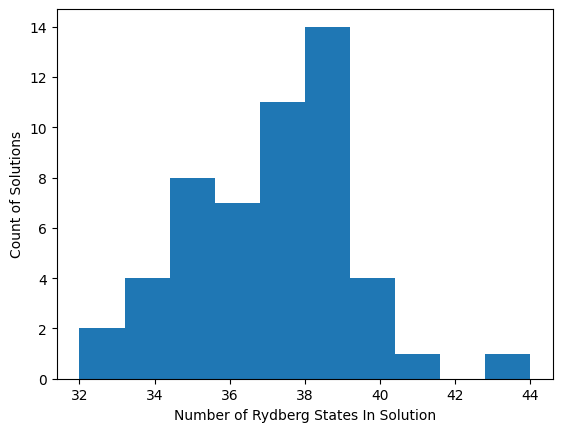

In [60]:
bitstrings = new_output.report().bitstrings()[0]
bitstring_length = len(bitstrings[0])
number_of_nodes_in_string = bitstring_length - np.sum(bitstrings, axis=1)
plt.hist(number_of_nodes_in_string)
plt.xlabel("Number of Rydberg States In Solution")
plt.ylabel("Count of Solutions")
plt.show()

In [64]:
dir(new_output)

['SubmissionException',
 '__annotations__',
 '__bloqade_deserializer__',
 '__bloqade_serializer__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_submit',
 'cancel',
 'fetch',
 'filter_metadata',
 'get_completed_tasks',
 'get_failed_tasks',
 'get_finished_tasks',
 'get_tasks',
 'json',
 'name',
 'pull',
 'remove_failed_tasks',
 'remove_invalid_tasks',
 'remove_tasks',
 'report',
 'resubmit',
 'retrieve',
 'set_deserializer',
 'set_serializer',
 'source',
 'tasks',
 'tasks_metric',
 'total_nshots']

In [70]:
new_output.filter_metadata()

                                             task ID     status  shots
0  arn:aws:braket:us-east-1:592242689881:quantum-...  Completed    100

In [73]:
dir(atom_pos)

['_ListOfLocations__n_atoms',
 '_ListOfLocations__n_dims',
 '_ListOfLocations__n_sites',
 '_ListOfLocations__n_vacant',
 '__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__parent__',
 '__pydantic_initialised__',
 '__pydantic_model__',
 '__pydantic_run_validation__',
 '__pydantic_validate_values__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__validate__',
 '__weakref__',
 '_add_position',
 '_repr_pretty_',
 'add_position',
 'apply',
 'apply_defect_count',
 'apply_defect_density',
 'children',
 'enumerate',
 'figure',
 'hyperfine',
 'location_list',
 'n_atoms',
 'n_dims',
 'n_sites',
 'n

In [74]:
atom_pos.location_list

[LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('0'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('4'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('8'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('12'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('16'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('24'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('28'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Literal(value=Decimal('32'))), filling=<SiteFilling.filled: 1>),
 LocationInfo(position=(Literal(value=Decimal('0')), Litera